In [1]:
import networkx as nx
import numpy as np
from queue import PriorityQueue
import ipywidgets as widgets
from copy import deepcopy
import torch
from utils import *
import torch.nn as nn
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, HTML
import logging

In [2]:
# Configure logging to output to PyCharm's console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

def add_node_with_edges(graph, node_name):
    """
    Add a node to the graph and allow the user to input related edges with direction using widgets in Jupyter Notebook.
    Displays immediate edge information on addition and logs actions to console.

    Parameters:
    graph (nx.DiGraph): The directed graph to add the node and edges to.
    node_name (str): The name of the node to add.

    Returns:
    None
    """
    # Add the node to the graph
    graph.add_node(node_name)
    display(HTML(f"<b>Notification:</b> Node '{node_name}' has been added to the graph."))
    logger.info(f"Node '{node_name}' has been added to the graph.")

    # Define output widget
    global node_dropdown, user_text, root_text, direction_dropdown, output
    output = widgets.Output()

    # Function to handle edge addition
    def add_edge(b):
        with output:
            clear_output(wait=True)
            display(HTML(f"<b>Notification:</b> Node '{node_name}' has been added to the graph."))
            logger.info(f"Add Edge button clicked for node '{node_name}'.")

            try:
                # Get widget values
                target_node = node_dropdown.value
                user_prob = float(user_text.value)
                root_prob = float(root_text.value)
                direction = direction_dropdown.value

                # Validate probabilities
                if not (0.0 <= user_prob <= 1.0 and 0.0 <= root_prob <= 1.0):
                    display(HTML("<b>Error:</b> Probabilities must be in the range [0.0, 1.0]. Please try again."))
                    logger.error(f"Invalid probabilities: user={user_prob}, root={root_prob}")
                    return

                # Prepare edge information
                edge_info = f"Edge Info: user={user_prob}, root={root_prob}, direction={direction}"

                # Add edge based on direction
                if direction == "To Target":
                    graph.add_edge(node_name, target_node, user=user_prob, root=root_prob)
                    edge_msg = f"Edge from '{node_name}' to '{target_node}' ({edge_info})"
                elif direction == "From Target":
                    graph.add_edge(target_node, node_name, user=user_prob, root=root_prob)
                    edge_msg = f"Edge from '{target_node}' to '{node_name}' ({edge_info})"
                else:  # Bidirectional
                    graph.add_edge(node_name, target_node, user=user_prob, root=root_prob)
                    graph.add_edge(target_node, node_name, user=user_prob, root=root_prob)
                    edge_msg = f"Bidirectional edge between '{node_name}' and '{target_node}' ({edge_info})"

                # Display and log edge info immediately
                display(HTML(f"<b>Notification:</b> {edge_msg} has been added."))
                logger.info(f"{edge_msg} has been added.")
                display_widgets()  # Redisplay widgets for next edge
            except ValueError:
                display(HTML("<b>Error:</b> Invalid input for probabilities. Please enter valid numbers."))
                logger.error("Invalid input for probabilities.")

    # Function to handle stopping
    def stop_adding(b):
        with output:
            clear_output(wait=True)
            display(HTML(f"<b>Notification:</b> Finished adding edges for node '{node_name}'."))
            logger.info(f"Finished adding edges for node '{node_name}'.")

    # Function to display widgets
    def display_widgets():
        with output:
            clear_output(wait=True)
            # Get list of existing nodes
            existing_nodes = list(graph.nodes())
            if not existing_nodes:
                display(HTML("<b>Warning:</b> No existing nodes in the graph."))
                logger.warning("No existing nodes in the graph.")
                return

            # Create widgets
            global node_dropdown, user_text, root_text, direction_dropdown
            node_dropdown = widgets.Dropdown(
                options=existing_nodes,
                description='Target Node:',
                disabled=False
            )
            user_text = widgets.FloatText(
                value=0.0,
                description='User Prob:',
                style={'description_width': 'initial'}
            )
            root_text = widgets.FloatText(
                value=0.0,
                description='Root Prob:',
                style={'description_width': 'initial'}
            )
            direction_dropdown = widgets.Dropdown(
                options=["To Target", "From Target", "Bidirectional"],
                description='Edge Direction:',
                disabled=False
            )
            add_button = widgets.Button(description="Add Edge")
            stop_button = widgets.Button(description="Stop")

            # Assign button callbacks with debug logging
            def on_add_button_clicked(b):
                logger.info("Add Edge button event triggered.")
                add_edge(b)

            def on_stop_button_clicked(b):
                logger.info("Stop button event triggered.")
                stop_adding(b)

            add_button.on_click(on_add_button_clicked)
            stop_button.on_click(on_stop_button_clicked)

            # Display widgets and initial message
            display(HTML(f"<b>Adding edges from/to '{node_name}':</b>"))
            display(node_dropdown, user_text, root_text, direction_dropdown, add_button, stop_button)

    # Initial display of widgets
    display(output)
    display_widgets()

In [15]:
# Original graph setup
G_original = nx.DiGraph()
G_original.add_nodes_from(["Attacker", "Data Server"])
edges = [
    ("Attacker", "Pad", {"user": 0.6, "root": 0.6}),
    ("Attacker", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Attacker", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 1", {"user": 0.6, "root": 0.48}),
    ("Pad", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Pad", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Pad", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Pad", {"user": 0.6, "root": 0.6}),
    ("Host 1", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Host 1", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Host 2", "Host 3", {"user": 0.8, "root": 0.8}),
    ("Host 2", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 2", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Host 2", {"user": 0.8, "root": 0.8}),
    ("Host 3", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 3", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Web Server", "File Server", {"user": 0.8, "root": 0.04}),
    ("Web Server", "Data Server", {"user": 0.8, "root": 0.04}),
    ("File Server", "Data Server", {"user": 0.8, "root": 0.04})
]
G_original.add_edges_from(edges)

G_new = G_original.copy()
add_node_with_edges(G_new, "New node")



2025-06-12 22:59:36,452 - INFO - Node 'New node' has been added to the graph.


Output()

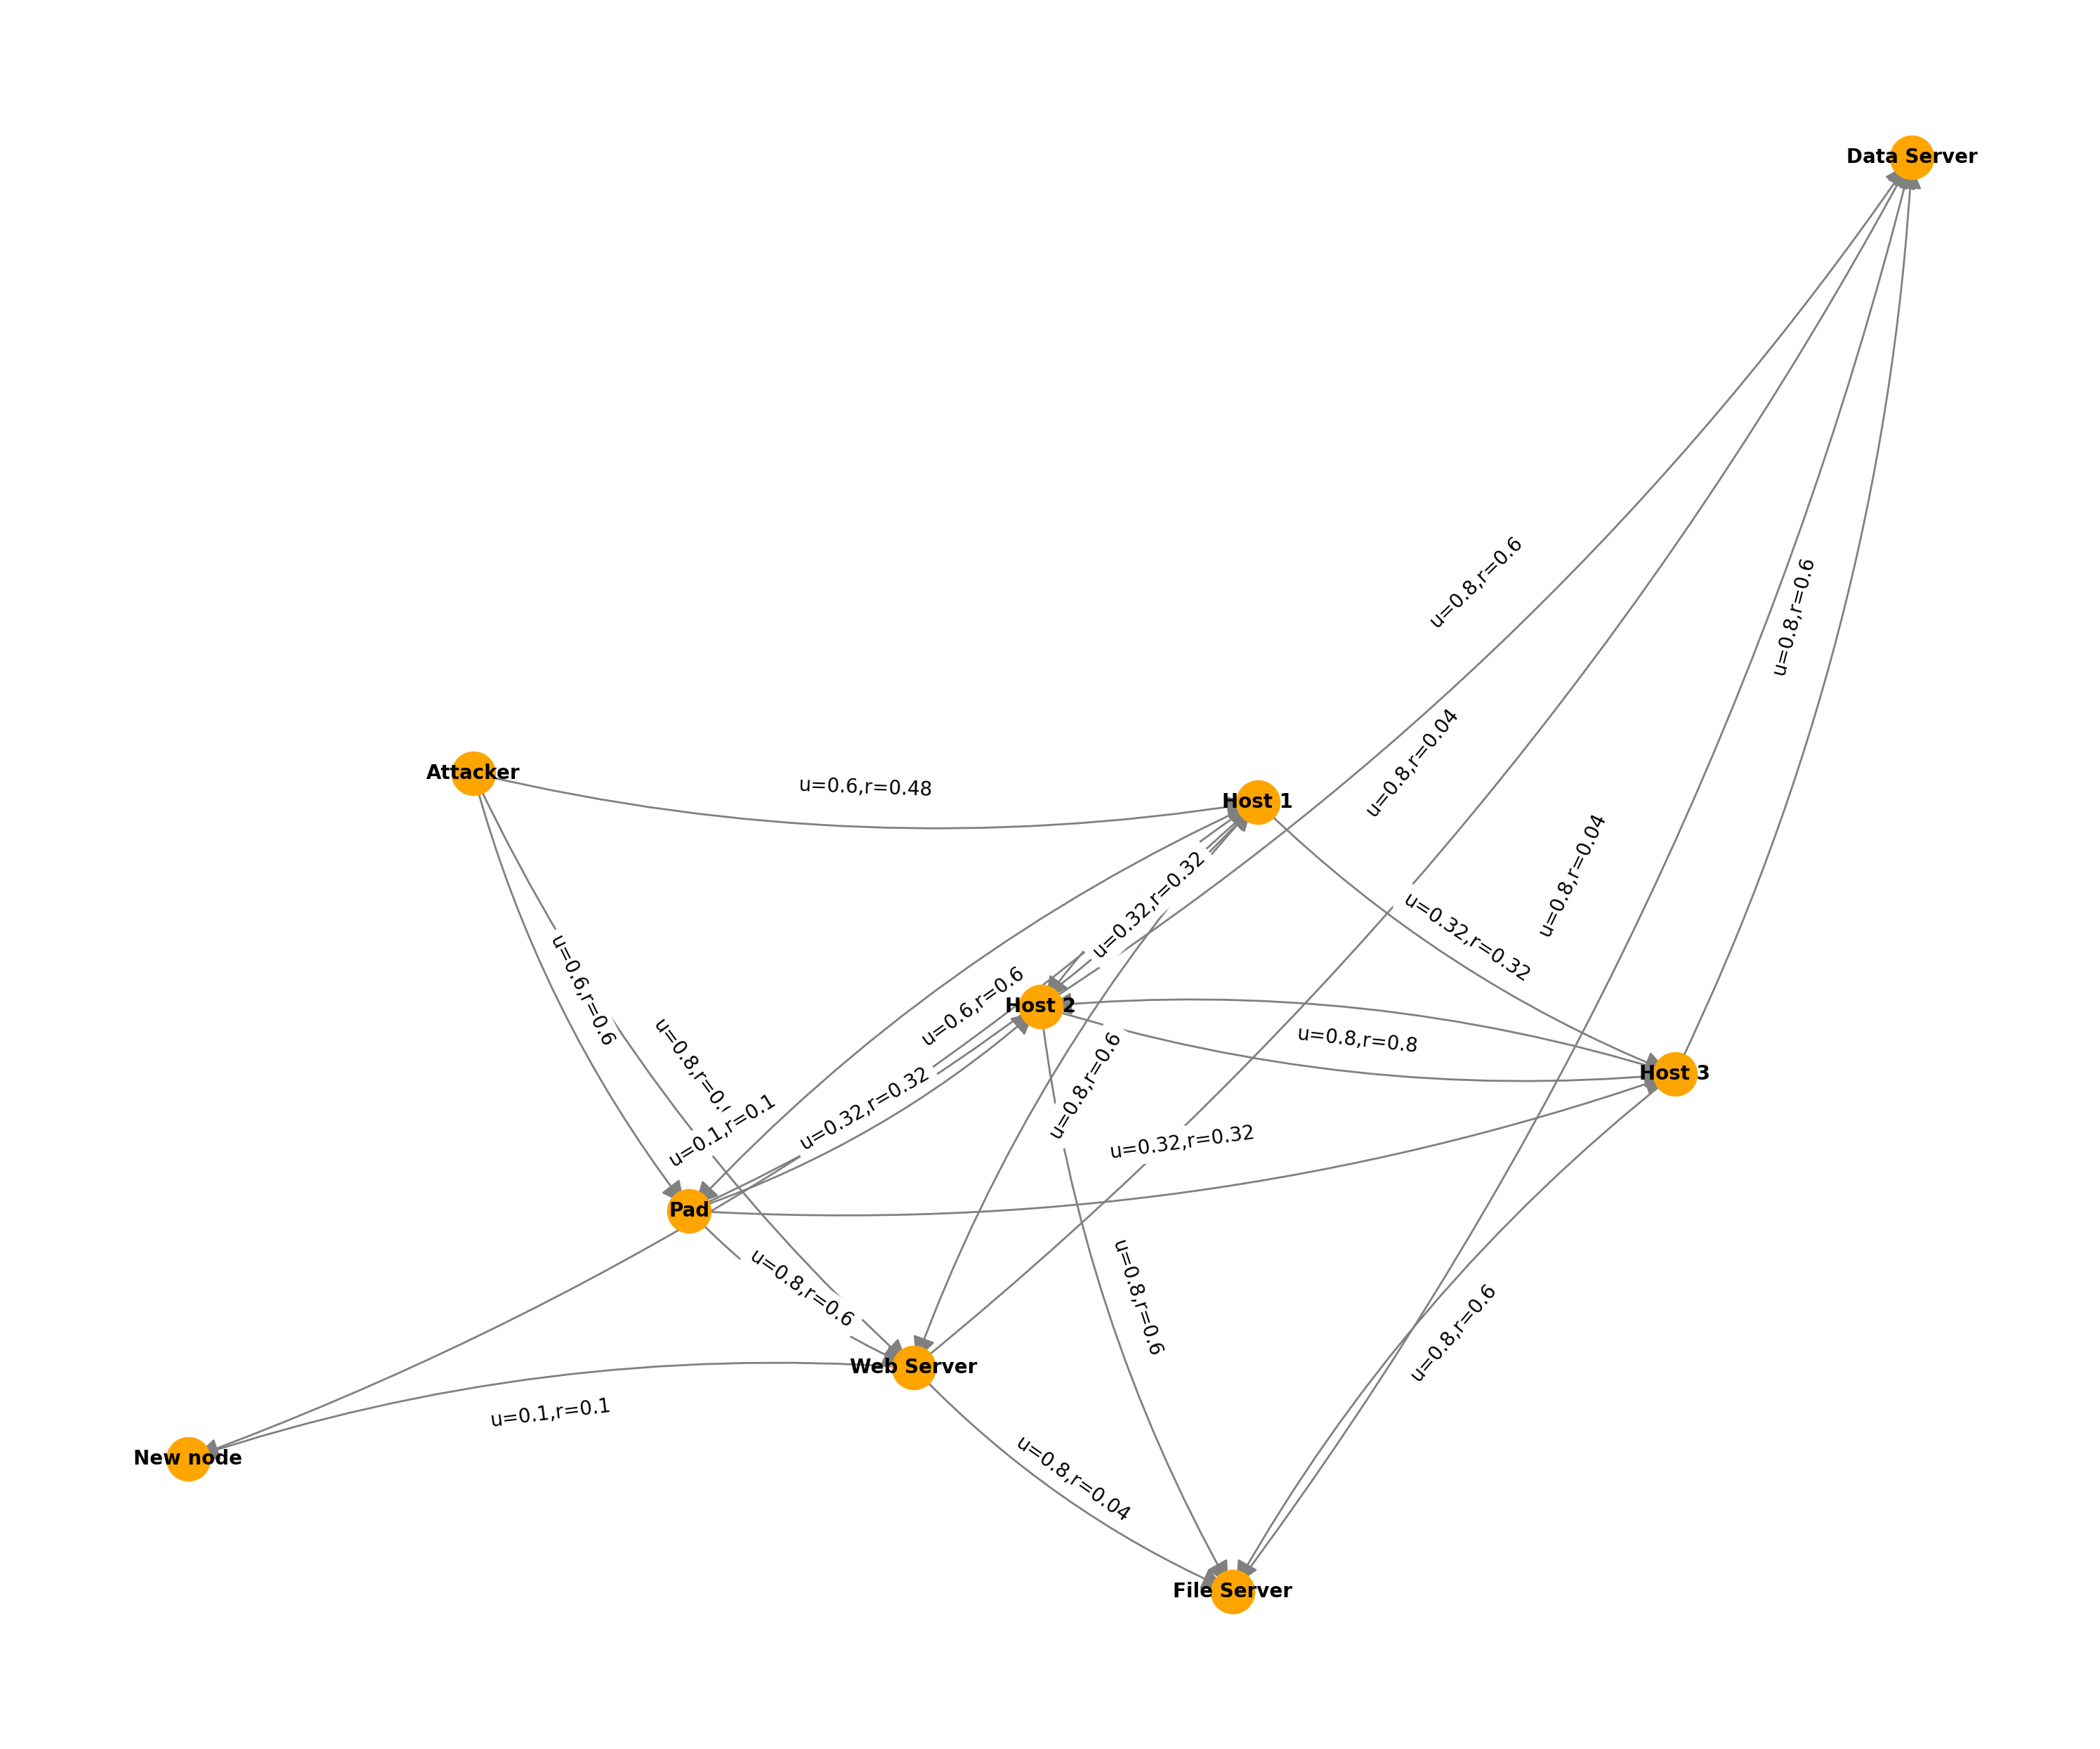

In [16]:

plt.figure(figsize=(30, 25))

# Cố định layout để lần nào cũng ra vị trí giống nhau
pos = nx.spring_layout(G_new, seed=42)

# Vẽ nodes
nx.draw_networkx_nodes(G_new, pos, node_color='orange', node_size=2000)

# Vẽ labels nodes
nx.draw_networkx_labels(G_new, pos, font_size=20, font_weight='bold')

# Vẽ edges với mũi tên và màu xám
nx.draw_networkx_edges(
    G_new, pos,
    edge_color='gray',
    arrows=True,
    arrowsize=50,
    width=2,
    connectionstyle='arc3,rad=0.1'  # Cạnh hơi cong cho đẹp
)

# Vẽ label trọng số cạnh
edge_labels = {(u, v): f"u={d['user']},r={d['root']}" for u, v, d in G_new.edges(data=True)}
nx.draw_networkx_edge_labels(G_new, pos, edge_labels=edge_labels, font_size=20)

plt.axis('off')
plt.tight_layout()

plt.savefig("graph.png")
plt.show()


In [17]:
class DQNWithBias(nn.Module):
    def __init__(self, base_model, old_num_nodes, new_num_nodes, old_honeypot_nodes, new_honeypot_nodes):
        super().__init__()
        self.model = base_model
        self.old_num_nodes = old_num_nodes
        self.new_num_nodes = new_num_nodes
        self.old_space_size = 2 * old_honeypot_nodes**2
        self.new_space_size = 2 * new_honeypot_nodes**2
        self.alpha = nn.Parameter(torch.Tensor([1]))
        self.beta = nn.Parameter(torch.Tensor([0]))

        # Tạo mask phân biệt action cũ và mới dựa trên cantor pairing
        self.register_buffer('is_old_mask', self._create_old_mask())
        print(self.is_old_mask)
    
    def _is_old_action(self, idx):
        x, y = inverse_cantor(idx)
        print(x,y)
        return x < (self.old_num_nodes-1) and y < (self.old_num_nodes-1)

    def _create_old_mask(self):
        mask = []
        for idx in range(self.new_space_size):
            mask.append(self._is_old_action(idx))
        return torch.tensor(mask, dtype=torch.bool)

    def forward(self, x):
        q_raw = self.model(x)  # shape: [batch_size, new_space_size]

        # Tách q_old và q_new bằng mask
        q_old = q_raw[:, self.is_old_mask]        # các action cũ
        q_new = q_raw[:, ~self.is_old_mask]       # các action mới

        # Áp dụng correction chỉ với phần action mới    
        q_new_corrected = self.alpha * q_new + self.beta

        # Kết hợp lại theo thứ tự action ban đầu
        q_corrected = torch.empty_like(q_raw)
        q_corrected[:, self.is_old_mask] = q_old
        q_corrected[:, ~self.is_old_mask] = q_new_corrected

        return q_corrected

In [18]:
# Khởi tạo môi trường để lấy kích thước
env_original = NetworkSecurityEnv(G_original, global_weighted_random_attack)
env_new = NetworkSecurityEnv(G_new, global_weighted_random_attack)

# Số node trong state (bao gồm Data Server, trừ Attacker)
old_num_nodes = env_original.num_nodes
new_num_nodes = env_new.num_nodes

# Không gian hành động dựa trên honeypot_nodes
old_action_space_size = env_original.get_action_space_size()
new_action_space_size = env_new.get_action_space_size()

model_old =  DQN(old_num_nodes, old_action_space_size)
model_load = torch.load("./Saved_Model/dqn_model.pth")
model_old.load_state_dict(model_load['policy_net_state_dict'])
model_new = DQN(new_num_nodes, new_action_space_size)


# 
with torch.no_grad():
    # Copy fc1, fc2, fc3 như bình thường
    model_new.fc1.weight[:, :old_num_nodes] = model_old.fc1.weight[:, :old_num_nodes]
    model_new.fc1.bias.copy_(model_old.fc1.bias)
    model_new.fc2.load_state_dict(model_old.fc2.state_dict())
    model_new.fc3.load_state_dict(model_old.fc3.state_dict())

    # Tập chỉ số toàn bộ action mới
    all_new_indices = set(range(new_action_space_size))

    # Tập các chỉ số action cũ đã copy
    old_indices_mapped = set()
    for idx in range(old_action_space_size):
        i, j = inverse_cantor(idx)
        if i < env_original.num_honeypot_nodes and j < env_original.num_honeypot_nodes:
            model_new.fc4.weight[idx].copy_(model_old.fc4.weight[idx])
            model_new.fc4.bias[idx].copy_(model_old.fc4.bias[idx])
            old_indices_mapped.add(idx)

    new_indices = list(all_new_indices - old_indices_mapped)

    # Khởi tạo phần mở rộng fc4.weight, bias cho các chỉ số mới
    for idx in new_indices:
        torch.nn.init.xavier_uniform_(model_new.fc4.weight[idx:idx+1])
        model_new.fc4.bias[idx] = 0.0

    torch.nn.init.xavier_uniform_(model_new.fc1.weight[:, old_num_nodes:])


node_to_idx: {'Data Server': 0, 'Pad': 1, 'Web Server': 2, 'Host 1': 3, 'Host 2': 4, 'Host 3': 5, 'File Server': 6}
node_to_idx: {'Data Server': 0, 'Pad': 1, 'Web Server': 2, 'Host 1': 3, 'Host 2': 4, 'Host 3': 5, 'File Server': 6, 'New node': 7}


In [19]:
print("FC4 weights:")
print(model_new.fc4.weight)

print("\nFC4 bias:")
print(model_new.fc4.bias)

FC4 weights:
Parameter containing:
tensor([[-0.0902,  0.0040, -0.0966,  ..., -0.0144, -0.0794, -0.0279],
        [-0.0811, -0.0026,  0.0090,  ..., -0.0360,  0.1184,  0.0296],
        [-0.0469,  0.0733,  0.0850,  ..., -0.0819,  0.1131, -0.0486],
        ...,
        [-0.1330, -0.2665,  0.1844,  ...,  0.2571, -0.0032,  0.2358],
        [-0.0276,  0.2915,  0.1533,  ...,  0.1081, -0.0357,  0.1045],
        [-0.1611, -0.0196,  0.2133,  ...,  0.2020,  0.1390,  0.1739]],
       requires_grad=True)

FC4 bias:
Parameter containing:
tensor([-0.0657,  0.1027,  0.0581, -0.0734,  0.1040, -0.2158, -0.1546,  0.1603,
        -0.0110,  0.1164, -0.2346,  0.0903,  0.0279, -0.0162, -0.3770, -0.1658,
         0.0652, -0.0649, -0.0223, -0.1231, -0.2252,  0.0000, -0.2378, -0.0111,
        -0.0450,  0.0645, -0.0188,  0.0000,  0.0000,  0.0000,  0.0025,  0.0562,
        -0.3015,  0.0065,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0673,
        -0.0419, -0.1748,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 

In [20]:
# Function to check if alpha is saturated
def is_alpha_saturated(alpha_history, k_consecutive, target_update_freq, alpha_threshold):
    """
    Check if the last k_consecutive episodes' alpha values are saturated.

    Args:
        alpha_history (list): List of alpha values recorded during training.
        k_consecutive (int): Number of consecutive episodes to check for saturation.
        target_update_freq (int): Frequency of alpha updates in episodes.
        alpha_threshold (float): Maximum allowed difference between consecutive alpha values.

    Returns:
        bool: True if alpha is saturated, False otherwise.
    """
    num_alpha_updates = k_consecutive // target_update_freq + (1 if k_consecutive % target_update_freq else 0)
    if len(alpha_history) < num_alpha_updates + 1:
        return False
    recent_alphas = alpha_history[-(num_alpha_updates + 1):]
    differences = [abs(recent_alphas[i] - recent_alphas[i-1]) for i in range(1, len(recent_alphas))]
    return all(diff < alpha_threshold for diff in differences)

In [21]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Khởi tạo môi trường và mô hình
env = NetworkSecurityEnv(G_new, global_weighted_random_attack)
model = DQNWithBias(model_new, old_num_nodes, new_num_nodes, env_original.num_honeypot_nodes, env_new.num_honeypot_nodes)

for name, param in model.model.named_parameters():
    if not ("fc4" in name or "fc1" in name):
        param.requires_grad = False

# Flag to track if bias correction is stopped
bias_correction_active = True

optimizer = torch.optim.SGD([
    {'params': [model.alpha], 'weight_decay': 0.0},
    {'params': [model.beta], 'weight_decay': 1e-4},
    {'params': [p for n, p in model.model.named_parameters() if "fc4" in n or "fc1" in n], 'weight_decay': 1e-4}
], lr=0.05, momentum=0.5)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5, verbose=True, min_lr=1e-5)
criterion = nn.MSELoss()

replay_buffer = ReplayBuffer(capacity=10000)

target_update_freq = batch_size = 15
num_episodes = batch_size * 14
losses = []

alpha_history = []
beta_history = []
episode_history = []
exploration_counter = defaultdict(int)
successes = 0
exploration_done = False

# Early stopping parameters for alpha saturation
k_consecutive = 50  # Number of consecutive episodes to check
alpha_threshold = 0.001  # Threshold for alpha difference

for episode in range(1, num_episodes + 1):
    state = env.reset()
    done = False
    total_loss = 0
    episode_steps = 0

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        if  exploration_done == False:
            action_idx, exploration_done = sample_exploration_index(new_action_space_size, env.num_honeypot_nodes, env_original.num_honeypot_nodes, exploration_counter, 10)

        else:
            with torch.no_grad():
                q_values = model(state_tensor).squeeze(0)  # shape: [action_space_size]
                valid_indices = [idx for idx in range(new_action_space_size) if is_valid_index(idx, env.num_honeypot_nodes)]
                valid_q_values = q_values[valid_indices]
                max_idx_in_valid = torch.argmax(valid_q_values).item()
                action_idx = valid_indices[max_idx_in_valid]

        action = index_to_action(action_idx, env.num_honeypot_nodes)
        next_state, reward, done, path, captured = env.step(action)
        replay_buffer.push(state, action_idx, reward, next_state, done)
        state = next_state
        episode_steps += 1

        honeypot_nodes = []
        for i in range(2):
            node_idx = np.argmax(action[i])
            honeypot_nodes.append(env.honeypot_nodes[node_idx])  # Sử dụng honeypot_nodes

        print("Episode:", episode)
        if reward == 1:
            print(path)
            print(f"Success\nHoneypots: {action}\nHoneypots connected to: {honeypot_nodes}\n")
            successes += 1
        elif reward == -1:
            print(path)
            print(f"Failed\nHoneypots: {action}\nHoneypots connected to: {honeypot_nodes}\n")

        if len(replay_buffer) >= batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            states_tensor = torch.FloatTensor(states)
            actions_tensor = torch.LongTensor(actions)
            rewards_tensor = torch.FloatTensor(rewards)
            next_states_tensor = torch.FloatTensor(next_states)
            dones_tensor = torch.FloatTensor(dones)

            if not (actions_tensor >= 0).all() or not (actions_tensor < new_action_space_size).all():
                print(f"Invalid actions in batch at episode {episode}")
                continue

            optimizer.zero_grad()
            q_pred = model(states_tensor)

            if torch.isnan(q_pred).any() or torch.isinf(q_pred).any():
                print(f"Warning: NaN or Inf in q_pred at episode {episode}")
                continue

            q_pred_actions = q_pred.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)

            with torch.no_grad():
                q_next = model(next_states_tensor)
                q_next_max = q_next.max(1)[0]
                q_target = rewards_tensor + (1 - dones_tensor) * 0.99 * q_next_max

            loss = criterion(q_pred_actions, q_target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    avg_loss = total_loss / max(episode_steps, 1)
    if episode >= batch_size:
        losses.append(avg_loss)
        scheduler.step(avg_loss)
    if episode % target_update_freq == 0:
        current_lr = optimizer.param_groups[0]['lr']
        alpha_history.append(model.alpha.item())
        beta_history.append(model.beta.item())
        episode_history.append(episode)

        # Check if alpha is saturated and bias correction should stop
        if bias_correction_active and is_alpha_saturated(alpha_history, k_consecutive, target_update_freq, alpha_threshold):
            print(f"\nStopping bias correction at episode {episode}: alpha has saturated (last {k_consecutive} episodes' alpha differences < {alpha_threshold})")
            # Freeze alpha and beta
            model.alpha.requires_grad = False
            model.beta.requires_grad = False
            # Reconfigure optimizer to exclude alpha and beta
            optimizer = torch.optim.SGD([
                {'params': [p for n, p in model.model.named_parameters() if "fc4" in n or "fc1" in n], 'weight_decay': 1e-4}
            ], lr=current_lr, momentum=0.5)
            bias_correction_active = False

dsp = (successes / num_episodes) * 100
print(f"\nDefense success probability: {dsp:.2f}%")

node_to_idx: {'Data Server': 0, 'Pad': 1, 'Web Server': 2, 'Host 1': 3, 'Host 2': 4, 'Host 3': 5, 'File Server': 6, 'New node': 7}
0 0
1 0
0 1
2 0
1 1
0 2
3 0
2 1
1 2
0 3
4 0
3 1
2 2
1 3
0 4
5 0
4 1
3 2
2 3
1 4
0 5
6 0
5 1
4 2
3 3
2 4
1 5
0 6
7 0
6 1
5 2
4 3
3 4
2 5
1 6
0 7
8 0
7 1
6 2
5 3
4 4
3 5
2 6
1 7
0 8
9 0
8 1
7 2
6 3
5 4
4 5
3 6
2 7
1 8
0 9
10 0
9 1
8 2
7 3
6 4
5 5
4 6
3 7
2 8
1 9
0 10
11 0
10 1
9 2
8 3
7 4
6 5
5 6
4 7
3 8
2 9
1 10
0 11
12 0
11 1
10 2
9 3
8 4
7 5
6 6
5 7
4 8
3 9
2 10
1 11
0 12
13 0
12 1
11 2
10 3
9 4
8 5
7 6
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True, False, False, False,
         True,  True,  True,  True, False, False, False, False, False,  True,
         True,  True, False, False, False, False, False, False, False,  True,
         True, False, False, False, False, False, False, False, False, 

In [22]:
print("FC4 weights:")
print(model_new.fc4.weight)

print("\nFC4 bias:")
print(model_new.fc4.bias)

FC4 weights:
Parameter containing:
tensor([[-0.0901,  0.0040, -0.0965,  ..., -0.0144, -0.0793, -0.0278],
        [-0.0810, -0.0026,  0.0090,  ..., -0.0360,  0.1184,  0.0296],
        [-0.0469,  0.0733,  0.0849,  ..., -0.0819,  0.1131, -0.0486],
        ...,
        [-0.1329, -0.2664,  0.1843,  ...,  0.2570, -0.0032,  0.2357],
        [-0.0276,  0.2914,  0.1533,  ...,  0.1080, -0.0357,  0.1045],
        [-0.1610, -0.0196,  0.2132,  ...,  0.2019,  0.1389,  0.1739]],
       requires_grad=True)

FC4 bias:
Parameter containing:
tensor([-0.0657,  0.1026,  0.0581, -0.0734,  0.1039, -0.2157, -0.1545,  0.1554,
        -0.0110,  0.1163, -0.2345,  0.0903,  0.0279, -0.0162, -0.3768, -0.1658,
         0.0651, -0.0649, -0.0223, -0.1231, -0.2251,  0.2993, -0.2377, -0.0111,
        -0.0450,  0.0645, -0.0188, -0.0291,  0.0000, -0.0787,  0.0025,  0.0561,
        -0.3014,  0.0065, -0.0047,  0.0000,  0.0000,  0.0000,  0.0636,  0.0673,
        -0.0419, -0.1747,  0.0936,  0.0000,  0.0000,  0.0000,  0.0000, 

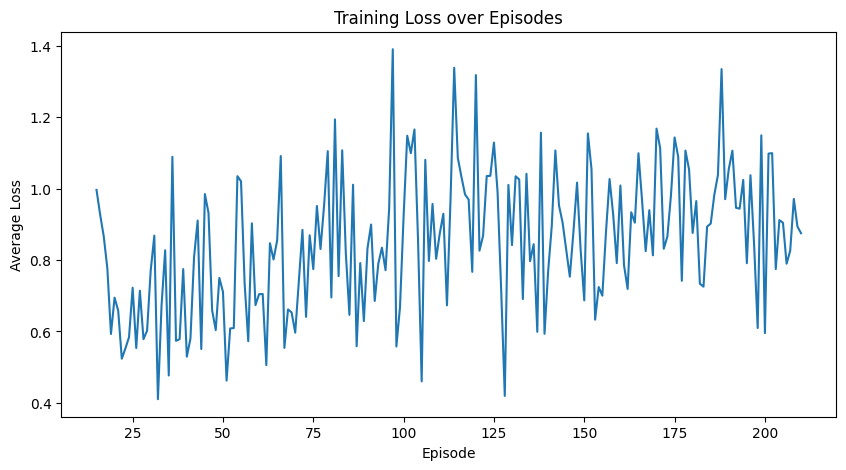

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(range(batch_size, num_episodes + 1), losses)
plt.xlabel('Episode')
plt.ylabel('Average Loss')
plt.title('Training Loss over Episodes')
plt.show()


In [24]:
print("FC4 weights:")
print(model_new.fc4.weight)

print("\nFC4 bias:")
print(model_new.fc4.bias)
print(np.argmax(model_new.fc4.weight.detach().numpy()))

print(np.argmax(model_new.fc4.bias.detach().numpy()))


FC4 weights:
Parameter containing:
tensor([[-0.0901,  0.0040, -0.0965,  ..., -0.0144, -0.0793, -0.0278],
        [-0.0810, -0.0026,  0.0090,  ..., -0.0360,  0.1184,  0.0296],
        [-0.0469,  0.0733,  0.0849,  ..., -0.0819,  0.1131, -0.0486],
        ...,
        [-0.1329, -0.2664,  0.1843,  ...,  0.2570, -0.0032,  0.2357],
        [-0.0276,  0.2914,  0.1533,  ...,  0.1080, -0.0357,  0.1045],
        [-0.1610, -0.0196,  0.2132,  ...,  0.2019,  0.1389,  0.1739]],
       requires_grad=True)

FC4 bias:
Parameter containing:
tensor([-0.0657,  0.1026,  0.0581, -0.0734,  0.1039, -0.2157, -0.1545,  0.1554,
        -0.0110,  0.1163, -0.2345,  0.0903,  0.0279, -0.0162, -0.3768, -0.1658,
         0.0651, -0.0649, -0.0223, -0.1231, -0.2251,  0.2993, -0.2377, -0.0111,
        -0.0450,  0.0645, -0.0188, -0.0291,  0.0000, -0.0787,  0.0025,  0.0561,
        -0.3014,  0.0065, -0.0047,  0.0000,  0.0000,  0.0000,  0.0636,  0.0673,
        -0.0419, -0.1747,  0.0936,  0.0000,  0.0000,  0.0000,  0.0000, 

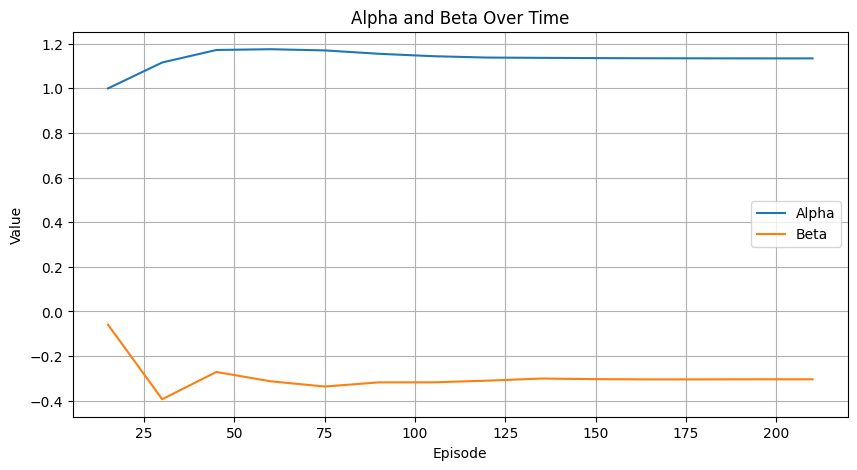

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(episode_history, alpha_history, label='Alpha')
plt.plot(episode_history, beta_history, label='Beta')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Alpha and Beta Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
evaluate_model(model, env)

Episode: 1
['Attacker', 'Host 1', 'Pad', 'Host 3', 'Web Server', 'Honeypot {Web Server}']
Success
Honeypots: [[0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['Host 1', 'Web Server']

Episode: 2
['Attacker', 'Pad', 'Host 1', 'Honeypot {Host 1}']
Success
Honeypots: [[0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['Host 1', 'Web Server']

Episode: 3
['Attacker', 'Pad', 'Web Server', 'File Server', 'Honeypot {Web Server}']
Success
Honeypots: [[0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['Host 1', 'Web Server']

Episode: 4
['Attacker', 'Web Server', 'File Server', 'Host 1', 'Data Server']
Failed
Honeypots: [[0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['Host 1', 'Web Server']

Episode: 5
['Attacker', 'Host 1', 'Pad', 'Host 3', 'Host 2', 'Web Server', 'Data Server']
Failed
Honeypots: [[0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
Honeypots connected to: ['Host 1', 'Web Server']

Episode